In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
train_val_data_dir = r'..\images\train'
img_height = 48
img_width = 48
batch_size = 128

# train DS
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',  # subfolderi - labele
    label_mode='categorical',   # labele - kao one hot encod
    validation_split=0.2, 
    subset = 'training',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
    #interpolation='bilinear' # opciono - metod, kod nas ne radimo resizing
)

train_class_names = train_ds.class_names
print(train_class_names)  

# validation DS (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',     
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
)

val_class_names = val_ds.class_names
print(val_class_names) 


# test DS
test_data_dir = r'..\images\test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)



Found 28821 files belonging to 7 classes.
Using 23057 files for training.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Za prebrojavanje slika po kategorijama:

In [3]:
def count_labels(dataset):
    counts = dict.fromkeys(dataset.class_names, 0)
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[dataset.class_names[i]] += 1
    return counts

In [4]:
print("Train dataset:", count_labels(train_ds))
print("Validation dataset:", count_labels(val_ds))
print("Test dataset:", count_labels(test_ds))

Train dataset: {'angry': 3229, 'disgust': 341, 'fear': 3294, 'happy': 5765, 'neutral': 3941, 'sad': 3935, 'surprise': 2552}
Validation dataset: {'angry': 764, 'disgust': 95, 'fear': 809, 'happy': 1399, 'neutral': 1041, 'sad': 1003, 'surprise': 653}
Test dataset: {'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


Prikaz prvih slika po kategorijama iz prvog batch-a: (random)

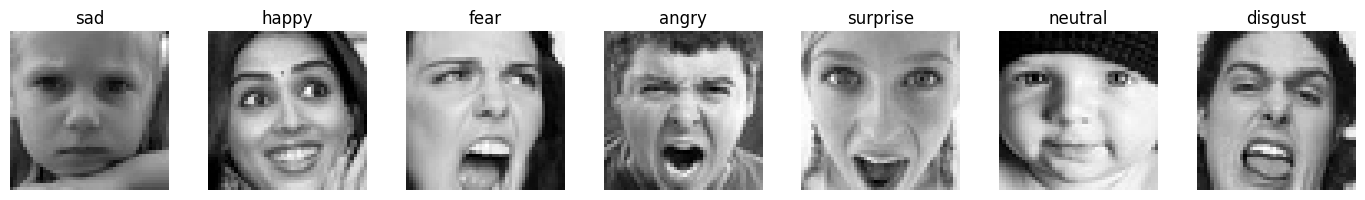

In [5]:

for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()
    class_names = train_ds.class_names

    first_of_class = {}  # prva slika po klasi

    for i in range(len(images)):
        class_index = np.argmax(labels[i])
        class_name = class_names[class_index]

        if class_name not in first_of_class:
            first_of_class[class_name] = images[i]

        if len(first_of_class) == len(class_names):
            break

    # broj klasa
    n_classes = len(class_names)
    fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona

    for ax, (class_name, image) in zip(axes, first_of_class.items()):
        ax.imshow(image.squeeze(), cmap='gray')  # squeeze ako je grayscale
        ax.set_title(class_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Normalizacija:

In [6]:
def normalize_images(x, y):
    x = tf.cast(x, tf.float32)
    x = (x - 0) / (255 - 0)      # min-max normalizacija
    return x, y

# primjena na sve dataset-ove
train_ds = train_ds.map(normalize_images)
val_ds   = val_ds.map(normalize_images)
test_ds  = test_ds.map(normalize_images)

Provjera px:

Train set - Min pixel: 0.0, Max pixel: 1.0
Validation set - Min pixel: 0.0, Max pixel: 1.0
Test set - Min pixel: 0.0, Max pixel: 1.0


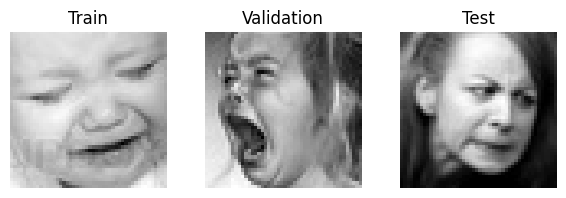

In [7]:
def show_first_images_in_row(train_ds, val_ds, test_ds):
    datasets = [train_ds, val_ds, test_ds]
    names = ["Train", "Validation", "Test"]
    images_to_show = []

    # uzmi prvu sliku iz svakog skupa
    for dataset, name in zip(datasets, names):
        for images, labels in dataset.take(1):
            image = images[0].numpy().squeeze()  # prva slika
            min_val = tf.reduce_min(images).numpy()
            max_val = tf.reduce_max(images).numpy()
            print(f"{name} set - Min pixel: {min_val}, Max pixel: {max_val}")
            images_to_show.append((image, name))

    # prikazi slike u jednom redu
    fig, axes = plt.subplots(1, len(images_to_show), figsize=(len(images_to_show)*2, 2))
    for ax, (image, name) in zip(axes, images_to_show):
        ax.imshow(image, cmap='gray')
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_first_images_in_row(train_ds, val_ds, test_ds)


Augmentacija train seta:

In [8]:
# Data augmentation - pozvati u modelu
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    #layers.RandomZoom(0.1)
])

In [14]:
def preprocess_to_rgb(img, label):
    img = tf.image.grayscale_to_rgb(img)  # 1 kanal -> 3 kanala
    return img, label

train_ds_rgb = train_ds.map(preprocess_to_rgb)
val_ds_rgb = val_ds.map(preprocess_to_rgb)
test_ds_rgb = test_ds.map(preprocess_to_rgb)

**VGG 19:**
parametri i rez, analiza!

In [31]:
#za racunanje f1 score radi prikaza na train i val - 1. NEEFIKASNO DA OPET PROLAZI
# class F1ScoreCallback(tf.keras.callbacks.Callback):
#     def __init__(self, train_data, val_data):
#         super().__init__()
#         self.train_data = train_data
#         self.val_data = val_data
#         self.train_f1 = []
#         self.val_f1 = []

#     def on_epoch_end(self, epoch, logs=None):
#         # --- Train F1 ---
#         y_true_train = np.concatenate([y for x, y in self.train_data], axis=0)
#         y_pred_prob_train = self.model.predict(self.train_data, verbose=0)
#         y_pred_train = np.argmax(y_pred_prob_train, axis=1)
#         y_true_train_classes = np.argmax(y_true_train, axis=1)
#         f1_train = f1_score(y_true_train_classes, y_pred_train, average='weighted', zero_division=0)
#         self.train_f1.append(f1_train)

#         # --- Validation F1 ---
#         y_true_val = np.concatenate([y for x, y in self.val_data], axis=0)
#         y_pred_prob_val = self.model.predict(self.val_data, verbose=0)
#         y_pred_val = np.argmax(y_pred_prob_val, axis=1)
#         y_true_val_classes = np.argmax(y_true_val, axis=1)
#         f1_val = f1_score(y_true_val_classes, y_pred_val, average='weighted', zero_division=0)
#         self.val_f1.append(f1_val)

#         print(f"\nEpoch {epoch+1} — Train F1: {f1_train:.4f}, Val F1: {f1_val:.4f}")


# Parametri
img_height = 48  # 2. vece slike za VGG19 ?
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 1e-4

# Data augmentation 3.
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    #layers.RandomZoom(0.1)
])

# VGG19 feature extractor
VGG19_model = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
VGG19_model.trainable = False 

# Build model
inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)  # augmentacija
x = VGG19_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)  # manje parametara nego Flatten
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x) #4.

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)


# Early stopping 
early_stop = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

model_checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True)
#f1_callback = F1ScoreCallback(train_ds_rgb, val_ds_rgb)


# Train model
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=2,  # vise epoha staviti 
    callbacks=[early_stop, model_checkpoint] #f1_callback]
)


# Evaluate on test set
eval_results = model.evaluate(test_ds_rgb)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report - 5. f1 samo za test ispis?
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = model.predict(test_ds_rgb)      #vjerovatnoce svake klase za svaki primjer
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))

Epoch 1/2
721/721 ━━━━━━━━━━━━━━━━━━━━ 610s 774ms/step - accuracy: 0.2178 - auc: 0.5972 - loss: 2.0532 - precision: 0.2838 - recall: 0.0407 - val_accuracy: 0.2929 - val_auc: 0.6857 - val_loss: 1.7885 - val_precision: 0.5171 - val_recall: 0.0184
Epoch 2/2
721/721 ━━━━━━━━━━━━━━━━━━━━ 585s 805ms/step - accuracy: 0.2823 - auc: 0.6768 - loss: 1.8280 - precision: 0.3996 - recall: 0.0466 - val_accuracy: 0.3135 - val_auc: 0.7203 - val_loss: 1.7166 - val_precision: 0.5324 - val_recall: 0.0257
221/221 ━━━━━━━━━━━━━━━━━━━━ 127s 574ms/step - accuracy: 0.3170 - auc: 0.7181 - loss: 1.7189 - precision: 0.5674 - recall: 0.0286        
Test results (loss, accuracy, precision, recall, AUC): [1.7188851833343506, 0.3170110285282135, 0.567415714263916, 0.028587602078914642, 0.7181306481361389]
221/221 ━━━━━━━━━━━━━━━━━━━━ 127s 568ms/step
F1 score: 0.3004000394004584
              precision    recall  f1-score   support

           0     0.2357    0.1969    0.2145       960
           1     0.0000    0.000

In [32]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])

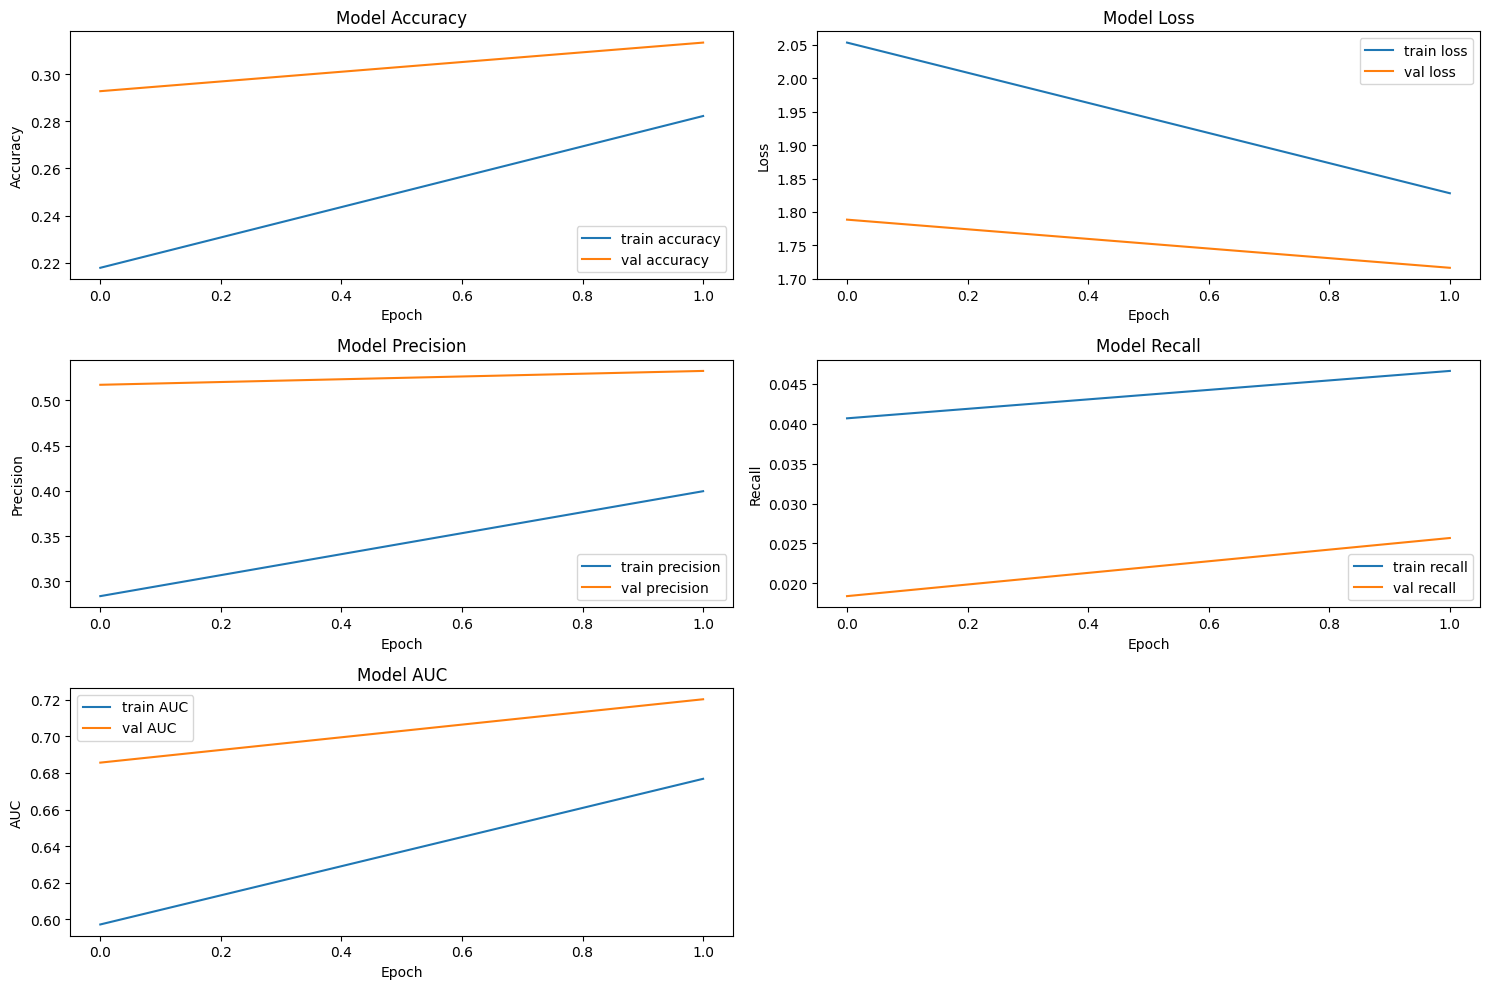

In [33]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

# F1
# plt.subplot(3,2,6)
# plt.plot(f1_callback.train_f1, label='train F1')
# plt.plot(f1_callback.val_f1, label='val F1')
# plt.title('F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('F1 Score')
# plt.legend()


plt.tight_layout()
plt.show()
